## 0. Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
import librosa
import librosa.display
from IPython.display import Audio

## 1. Visualization of one sample

In [3]:
SAMPLE_FILE = 'EmoDB/03a01Fa.wav'

# load the audio file to get the sample
samples, sample_rate = librosa.load(SAMPLE_FILE, sr = None)

In [4]:
samples.shape

(30372,)

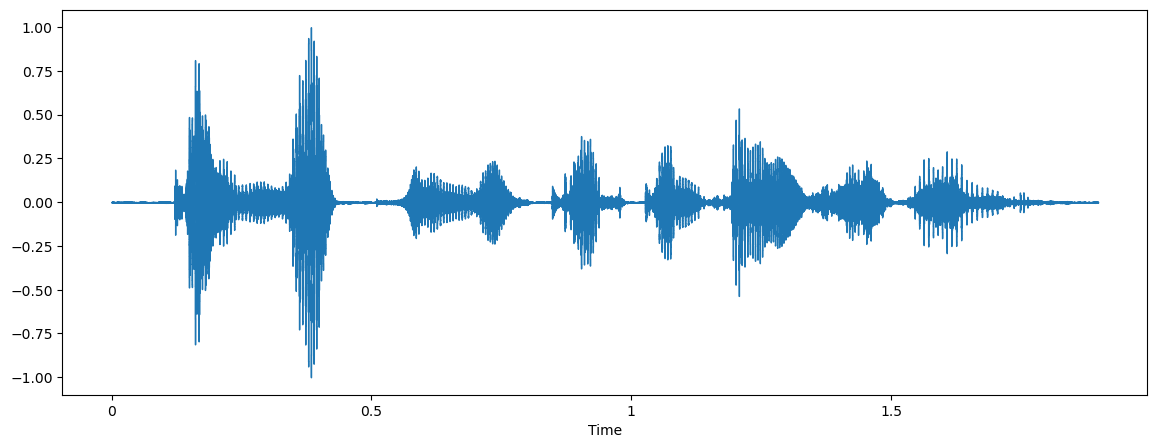

In [5]:
# visualize the sound wave
plt.figure(figsize = (14, 5))
librosa.display.waveshow(samples, sr = sample_rate)

In [6]:
# play the audio directly
Audio(SAMPLE_FILE)

In [7]:
print ('Sample shape ', samples.shape, 'Sample rate ', sample_rate, 'Data type', type(samples))

Sample shape  (30372,) Sample rate  16000 Data type <class 'numpy.ndarray'>


/opt/conda/lib/python3.7/site-packages/librosa/util/decorators.py:88: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  return f(*args, **kwargs)


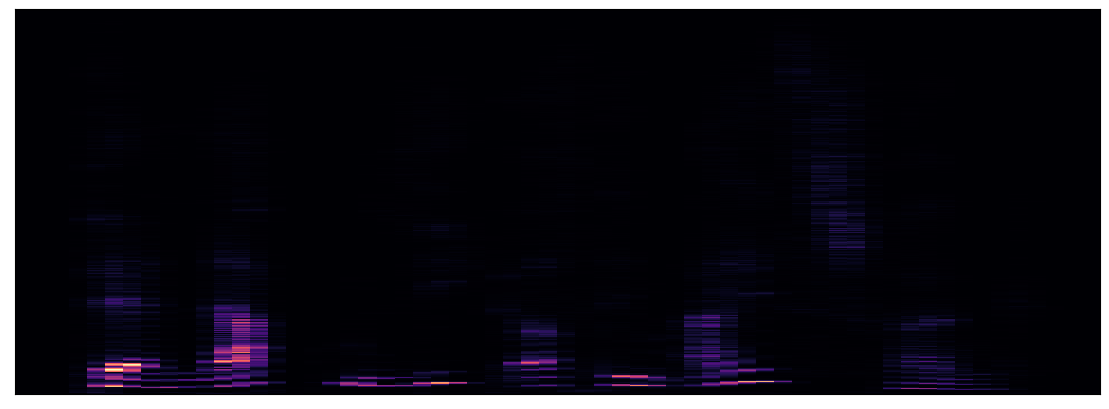

In [8]:
# Spectrograms: plot frequency vs time to indicate the Amplitude of each frequency
plt.figure(figsize = (14, 5))
sgram = librosa.stft(samples)
librosa.display.specshow(sgram)

<Figure size 1400x500 with 0 Axes>

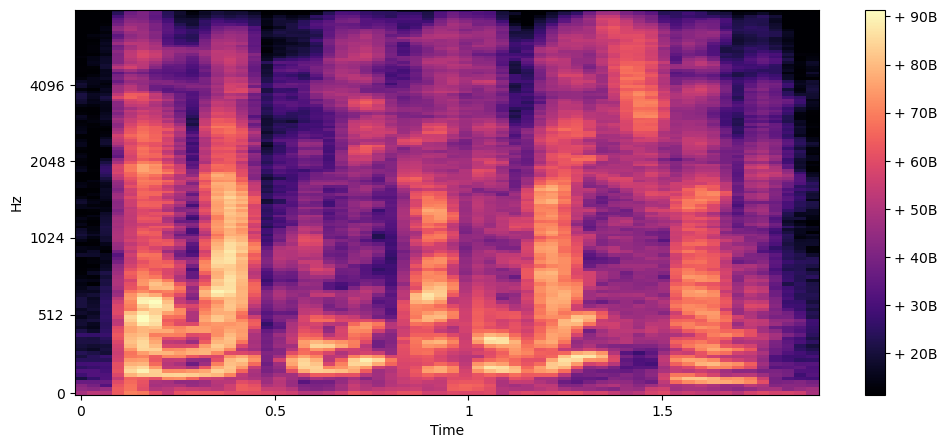

In [9]:
# Modify the to use Mel Scale (a scale of pitches, s.t. each unit is judged by listeners to be equal in pitches distance from the next) instead of Frequency
plt.figure(figsize = (14, 5))
sgram_mag, _ = librosa.magphase(sgram)
mel_scale_sgram = librosa.feature.melspectrogram(S = sgram_mag, sr = sample_rate)
# use the decibel scale to get the final Mel Spectrogram
plt.figure(figsize = (12, 5))
mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
librosa.display.specshow(mel_sgram, sr=sample_rate, x_axis='time', y_axis='mel')
plt.colorbar(format='+% dB')

## 2. Overall Exploration

In [10]:
path = 'EmoDB'
entries = os.listdir(path)

In [11]:
emotion_counter = dict()
emotions = {
    'W': 'angry',
    'L': 'bored',
    'E': 'disgust',
    'A': 'anxious',
    'F': 'happy',
    'T': 'sad',
    'N': 'neutral'
}

for entry in entries:
    emo = emotions[entry[5]]
    # emo = entry[5]
    if emo not in emotion_counter:
        emotion_counter[emo] = 0
    emotion_counter[emo] += 1

In [12]:
print(f'Total sample number: {len(entries)}')
print(f'Distinct emotion number: {len(emotion_counter)}\n')
print("------ Sample numbers ------")
for emo in emotion_counter:
    print(f'{emo}: {emotion_counter[emo]}')

Total sample number: 535
Distinct emotion number: 7

------ Sample numbers ------
angry: 127
neutral: 79
bored: 81
happy: 71
disgust: 46
anxious: 69
sad: 62


In [13]:
# create a dataframe to store filename with its category
df = pd.DataFrame({'fileName': entries})
df['Category'] = df.apply(lambda row: row[0][5], axis=1)

<AxesSubplot:ylabel='Frequency'>

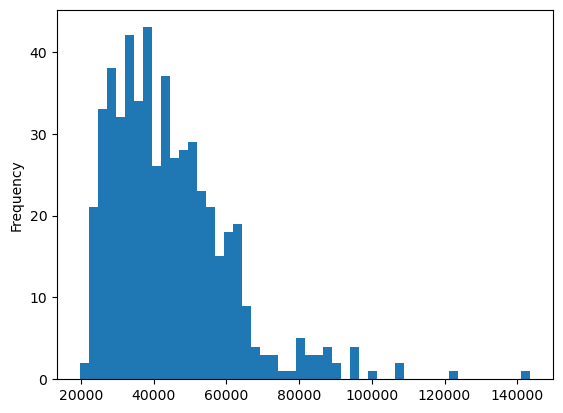

In [14]:
df['audio_len'] = 0
df['sample_rate'] = 0

for i in range(len(df)):
  entry = df.iloc[i,0]
  file_path = path +'/'+ entry
  sample, sample_rate = librosa.load(file_path, sr = None)
  df.iloc[i,2] = len(sample)
  df.iloc[i,3] = sample_rate

df['audio_len'].plot.hist(bins = 50) #(bins=12, alpha=0.5)

<AxesSubplot:xlabel='audio_len', ylabel='Category'>

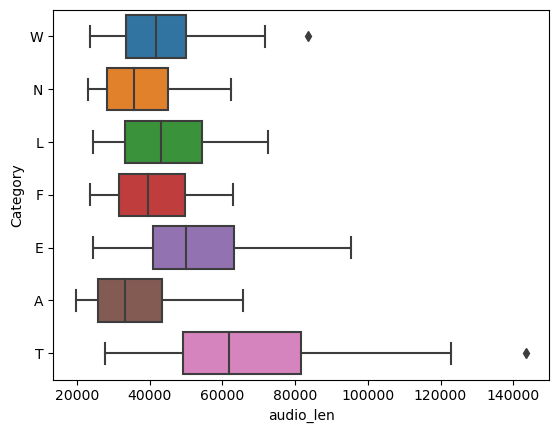

In [15]:
# plt.plot(df['audio_len'], df['Category'], 'o')
import seaborn as sns
sns.boxplot(x=df["audio_len"], y=df["Category"])
# df.boxplot(column = 'audio_len', by='Category')

## 3. Wave2Vec

In [343]:
layer = 11

### 3.1 model

In [344]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

1.12.1+cu113
0.12.1+cu113
cuda


In [345]:
bundle = torchaudio.pipelines.WAV2VEC2_BASE

print("Sample Rate:", bundle.sample_rate)

Sample Rate: 16000


In [346]:
model = bundle.get_model().to(device)

print(model.__class__)

<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [ ]:
import os
path = 'EmoDB/'
entries = os.listdir(path)
audios = []
labels = []

for file in entries:
    if 'wav' not in file:
        continue
    file_path = path + file
    label = emotions[file[5]]
    labels.append(label)
    wave, sr = torchaudio.load(file_path)
    wave = wave.to(device)
    if sr != bundle.sample_rate:
        wave = torchaudio.functional.resample(wave, sr, bundle.sample_rate)
    with torch.inference_mode():
        features, _ = model.extract_features(wave)
    audios.append(features[layer][0])

In [ ]:
audios[1].shape

torch.Size([120, 768])

In [ ]:
audios[-1].shape

torch.Size([129, 768])

In [ ]:
class MyDataSet(torch.utils.data.Dataset):
    def __init__(self, data, label, label_transform):
        super(MyDataSet).__init__()
        self.data = data
        self.label = label
        self.label_transform = label_transform
        
    def __getitem__(self, idx):
        audio = self.data[idx]
        label = self.label_transform[self.label[idx]]
        length = self.data[idx].size(0)
        return audio, length, label
    
    def __len__(self):
        return len(self.label)

In [ ]:
categories = emotions.values()
cate_dic = {}
for i, cate in enumerate(categories):
    cate_dic[cate] = i
cate_dic

{'angry': 0,
 'bored': 1,
 'disgust': 2,
 'anxious': 3,
 'happy': 4,
 'sad': 5,
 'neutral': 6}

In [ ]:
def collate_indic(data):

    _, lengths, labels = zip(*data)
    max_len = max(lengths)
    n_ftrs = data[0][0].size(1)
    features = torch.zeros((len(data), max_len, n_ftrs))
    labels = torch.tensor(labels)
    lengths = torch.tensor(lengths)

    for i in range(len(data)):
        j, k = data[i][0].size(0), data[i][0].size(1)
        features[i] = torch.cat([data[i][0], torch.zeros((max_len - j, k)).to(device)])

    return features, lengths, labels


In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

X_train, X_test, y_train, y_test = train_test_split(audios, labels, test_size=0.2, random_state=42)

train_dataset = MyDataSet(X_train, y_train, cate_dic)
trainloader_args = dict(batch_size=64, shuffle=True)
train_dataloader = DataLoader(train_dataset, **trainloader_args, collate_fn=collate_indic)

test_dataset = MyDataSet(X_test, y_test, cate_dic)
testloader_args = dict(batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, **testloader_args, collate_fn=collate_indic)

In [ ]:
for batch, data in enumerate(train_dataloader):
    x, length, y = data
    print(batch, x.shape)

0 torch.Size([64, 267, 768])
1 torch.Size([64, 448, 768])
2 torch.Size([64, 297, 768])
3 torch.Size([64, 339, 768])
4 torch.Size([64, 257, 768])
5 torch.Size([64, 383, 768])
6 torch.Size([44, 224, 768])


## 4. Data Visualization

In [ ]:
audios_dv = [torch.mean(audio, dim=0).tolist() for audio in audios]

cate_audios = []
cate_labels = []
for i in range(len(audios_dv)):
  if True:
    cate_audios.append(audios_dv[i])
    cate_labels.append(labels[i])

In [ ]:
data = pd.DataFrame({'Label':cate_labels, 'Features': cate_audios})
data = data.sort_values('Label', ignore_index=True)
data.head()

,Label,Features
0,angry,"[0.10446180403232574, 0.21356448531150818, 0.0..."
1,angry,"[-0.052440620958805084, 0.1592589169740677, 0...."
2,angry,"[-0.05819793418049812, 0.15828637778759003, 0...."
3,angry,"[-0.029055580496788025, 0.2673887014389038, 0...."
4,angry,"[-0.18000832200050354, 0.13485603034496307, 0...."


In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=20)
output = tsne.fit_transform(cate_audios)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


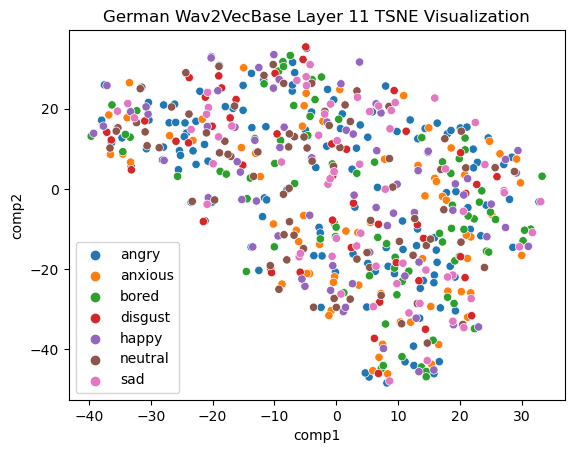

FileNotFoundError: [Errno 2] No such file or directory: 'tsne/Wav2Vec/German Wav2VecBase Layer 11 TSNE Visualization.png'

<Figure size 640x480 with 0 Axes>

In [ ]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame(output, columns=['comp1', 'comp2'])
sns.scatterplot(x='comp1', y='comp2', hue=data['Label'].tolist(), data=df)
plt.title(f'German Wav2VecBase Layer {layer} TSNE Visualization')
plt.show()
plt.savefig(f'tsne/Wave2Vec/German Wav2VecBase Layer {layer} TSNE Visualization.png', bbox_inches='tight')

## 5. CNN

In [331]:
import torch.nn as nn
import torch.nn.functional as F

class ICASSP3CNN(nn.Module):
    def __init__(self, vocab_size, embed_size=128, hidden_size=512, num_lstm_layers = 2, bidirectional = False, label_size=7):
        super().__init__()
        self.n_layers = num_lstm_layers 
        self.hidden = hidden_size
        self.bidirectional = bidirectional
        
        self.embed = nn.Linear(in_features = vocab_size, out_features = embed_size)

        self.cnn  = nn.Conv1d(embed_size, embed_size, kernel_size=3, padding=1)
        self.cnn2 = nn.Conv1d(embed_size, embed_size, kernel_size=5, padding=2)
        self.cnn3 = nn.Conv1d(embed_size, embed_size, kernel_size=7, padding=3)

        self.batchnorm = nn.BatchNorm1d(3 * embed_size)

        self.lstm = nn.LSTM(input_size = 3 * embed_size, 
                            hidden_size = hidden_size, 
                            num_layers = num_lstm_layers, 
                            bidirectional = bidirectional)

        self.linear = nn.Linear(in_features = 2 * hidden_size if bidirectional else hidden_size, 
                                out_features = label_size)


    def forward(self, x, lengths):
        """
        padded_x: (B,T) padded LongTensor
        """

        input = self.embed(x)

        batch_size = input.size(0)
        input = input.transpose(1,2)    # (B,T,H) -> (B,H,T)

        cnn_output = torch.cat([self.cnn(input), self.cnn2(input), self.cnn3(input)], dim=1)

        input = F.relu(self.batchnorm(cnn_output))

        input = input.transpose(1,2)

        pack_tensor = nn.utils.rnn.pack_padded_sequence(input, lengths, batch_first=True, enforce_sorted=False)
        _, (hn, cn) = self.lstm(pack_tensor)

        if self.bidirectional:
            h_n = hn.view(self.n_layers, 2, batch_size, self.hidden)
            h_n = torch.cat([ h_n[-1, 0,:], h_n[-1,1,:] ], dim = 1)
        else:
            h_n = hn[-1]

        logits = self.linear(h_n)

        return logits


In [332]:
model = ICASSP3CNN(768, bidirectional=True)

In [333]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model = model.to(device)

In [334]:
from tqdm import tqdm

epochs = 40
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

for epoch in tqdm(range(epochs)):
    train_loss = 0
    acc_cnt = 0
    err_cnt = 0
    batch_cnt = 0
    model.train()
    for batch, (x, length, y) in enumerate(train_dataloader):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        logits = model(x, length)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.cpu().item()

        #model outputs
        out_val, out_indices = torch.max(logits, dim=1)
        tar_indices = y

        for i in range(len(out_indices)):
            if out_indices[i] == tar_indices[i]:
                acc_cnt += 1
            else:
                err_cnt += 1
        batch_cnt += 1
    
    train_loss = train_loss/batch_cnt
    train_accuracy = acc_cnt/(acc_cnt+err_cnt)
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)
    
    valid_loss = 0
    acc_cnt = 0
    err_cnt = 0
    batch_cnt = 0
    model.eval()

    for x, lengths, y in test_dataloader:

        x = x.to(device)
        y = y.to(device)

        logits = model(x, lengths)
        loss = criterion(logits, y)
        valid_loss += loss.cpu().item()

        out_val, out_indices = torch.max(logits, dim=1)
        tar_indices = y

        for i in range(len(out_indices)):
            if out_indices[i] == tar_indices[i]:
                acc_cnt += 1
            else:
                err_cnt += 1
        batch_cnt += 1
    
    valid_loss = valid_loss/batch_cnt
    valid_accuracy = acc_cnt/(acc_cnt+err_cnt)
    valid_accuracies.append(valid_accuracy)
    valid_losses.append(valid_loss)
    
    print(f"epoch:{epoch+1}, train accu:{train_accuracy:.4f}, train loss:{train_loss:.2f},valid accu:{valid_accuracy:.4f}, valid loss:{valid_loss:.2f}")

  2%|▎         | 1/40 [00:02<01:32,  2.37s/it]

epoch:1, train accu:0.3575, train loss:1.67,valid accu:0.5701, valid loss:1.63


  5%|▌         | 2/40 [00:04<01:28,  2.34s/it]

epoch:2, train accu:0.5607, train loss:1.10,valid accu:0.5794, valid loss:1.24


  8%|▊         | 3/40 [00:07<01:26,  2.34s/it]

epoch:3, train accu:0.6402, train loss:0.89,valid accu:0.5888, valid loss:0.95


 10%|█         | 4/40 [00:09<01:23,  2.33s/it]

epoch:4, train accu:0.7757, train loss:0.61,valid accu:0.5981, valid loss:0.90


 12%|█▎        | 5/40 [00:11<01:21,  2.33s/it]

epoch:5, train accu:0.8481, train loss:0.44,valid accu:0.6636, valid loss:0.94


 15%|█▌        | 6/40 [00:14<01:19,  2.35s/it]

epoch:6, train accu:0.9136, train loss:0.26,valid accu:0.6262, valid loss:1.25


 18%|█▊        | 7/40 [00:16<01:17,  2.34s/it]

epoch:7, train accu:0.9136, train loss:0.24,valid accu:0.7757, valid loss:0.75


 20%|██        | 8/40 [00:18<01:14,  2.34s/it]

epoch:8, train accu:0.9159, train loss:0.22,valid accu:0.6916, valid loss:1.09


 22%|██▎       | 9/40 [00:21<01:12,  2.35s/it]

epoch:9, train accu:0.9276, train loss:0.19,valid accu:0.6355, valid loss:1.50


 25%|██▌       | 10/40 [00:23<01:10,  2.34s/it]

epoch:10, train accu:0.9533, train loss:0.14,valid accu:0.7944, valid loss:0.78


 28%|██▊       | 11/40 [00:25<01:07,  2.32s/it]

epoch:11, train accu:0.9533, train loss:0.12,valid accu:0.7477, valid loss:0.82


 30%|███       | 12/40 [00:27<01:04,  2.31s/it]

epoch:12, train accu:0.9579, train loss:0.12,valid accu:0.6449, valid loss:1.59


 32%|███▎      | 13/40 [00:30<01:02,  2.31s/it]

epoch:13, train accu:0.9743, train loss:0.08,valid accu:0.7477, valid loss:0.94


 35%|███▌      | 14/40 [00:32<01:00,  2.31s/it]

epoch:14, train accu:0.9790, train loss:0.05,valid accu:0.6916, valid loss:1.18


 38%|███▊      | 15/40 [00:34<00:57,  2.30s/it]

epoch:15, train accu:0.9836, train loss:0.05,valid accu:0.7757, valid loss:0.95


 40%|████      | 16/40 [00:37<00:55,  2.30s/it]

epoch:16, train accu:0.9953, train loss:0.02,valid accu:0.7383, valid loss:1.06


 42%|████▎     | 17/40 [00:39<00:52,  2.30s/it]

epoch:17, train accu:0.9883, train loss:0.05,valid accu:0.6916, valid loss:1.25


 45%|████▌     | 18/40 [00:41<00:50,  2.29s/it]

epoch:18, train accu:0.9907, train loss:0.02,valid accu:0.7757, valid loss:1.08


 48%|████▊     | 19/40 [00:43<00:47,  2.28s/it]

epoch:19, train accu:0.9930, train loss:0.03,valid accu:0.8318, valid loss:0.76


 50%|█████     | 20/40 [00:46<00:45,  2.26s/it]

epoch:20, train accu:0.9977, train loss:0.01,valid accu:0.7570, valid loss:1.04


 52%|█████▎    | 21/40 [00:48<00:43,  2.30s/it]

epoch:21, train accu:1.0000, train loss:0.01,valid accu:0.7477, valid loss:1.38


 55%|█████▌    | 22/40 [00:50<00:41,  2.32s/it]

epoch:22, train accu:0.9953, train loss:0.02,valid accu:0.7103, valid loss:1.81


 57%|█████▊    | 23/40 [00:53<00:39,  2.31s/it]

epoch:23, train accu:0.9136, train loss:0.34,valid accu:0.7383, valid loss:0.72


 60%|██████    | 24/40 [00:55<00:36,  2.29s/it]

epoch:24, train accu:0.9276, train loss:0.18,valid accu:0.7383, valid loss:0.76


 62%|██████▎   | 25/40 [00:57<00:34,  2.29s/it]

epoch:25, train accu:0.9229, train loss:0.20,valid accu:0.7477, valid loss:0.83


 65%|██████▌   | 26/40 [01:00<00:31,  2.28s/it]

epoch:26, train accu:0.9439, train loss:0.16,valid accu:0.7103, valid loss:1.05


 68%|██████▊   | 27/40 [01:02<00:29,  2.27s/it]

epoch:27, train accu:0.9650, train loss:0.11,valid accu:0.6822, valid loss:1.05


 70%|███████   | 28/40 [01:04<00:27,  2.25s/it]

epoch:28, train accu:0.9603, train loss:0.12,valid accu:0.7383, valid loss:1.01


 72%|███████▎  | 29/40 [01:06<00:24,  2.25s/it]

epoch:29, train accu:0.9743, train loss:0.07,valid accu:0.7570, valid loss:0.86


 75%|███████▌  | 30/40 [01:09<00:22,  2.25s/it]

epoch:30, train accu:0.9813, train loss:0.05,valid accu:0.7009, valid loss:0.93


 78%|███████▊  | 31/40 [01:11<00:20,  2.27s/it]

epoch:31, train accu:0.9930, train loss:0.04,valid accu:0.7850, valid loss:0.90


 80%|████████  | 32/40 [01:13<00:18,  2.27s/it]

epoch:32, train accu:0.9977, train loss:0.01,valid accu:0.7850, valid loss:0.83


 82%|████████▎ | 33/40 [01:15<00:15,  2.26s/it]

epoch:33, train accu:0.9907, train loss:0.02,valid accu:0.7850, valid loss:0.95


 85%|████████▌ | 34/40 [01:18<00:13,  2.24s/it]

epoch:34, train accu:0.9930, train loss:0.02,valid accu:0.7570, valid loss:1.07


 88%|████████▊ | 35/40 [01:20<00:11,  2.25s/it]

epoch:35, train accu:1.0000, train loss:0.01,valid accu:0.7664, valid loss:0.87


 90%|█████████ | 36/40 [01:22<00:09,  2.27s/it]

epoch:36, train accu:1.0000, train loss:0.00,valid accu:0.8037, valid loss:0.79


 92%|█████████▎| 37/40 [01:24<00:06,  2.26s/it]

epoch:37, train accu:0.9977, train loss:0.01,valid accu:0.7477, valid loss:1.11


 95%|█████████▌| 38/40 [01:27<00:04,  2.27s/it]

epoch:38, train accu:0.9977, train loss:0.01,valid accu:0.7850, valid loss:0.86


 98%|█████████▊| 39/40 [01:29<00:02,  2.27s/it]

epoch:39, train accu:0.9930, train loss:0.02,valid accu:0.7944, valid loss:0.78


100%|██████████| 40/40 [01:31<00:00,  2.29s/it]

epoch:40, train accu:1.0000, train loss:0.00,valid accu:0.8224, valid loss:0.86


In [335]:
model_path = 'EmoDB_models/wav2vec_base.pth'

torch.save({'epoch':epochs,
            'model_state_dict':model.state_dict(),
            'optimizer_state_dict':optimizer.state_dict()},
            model_path)

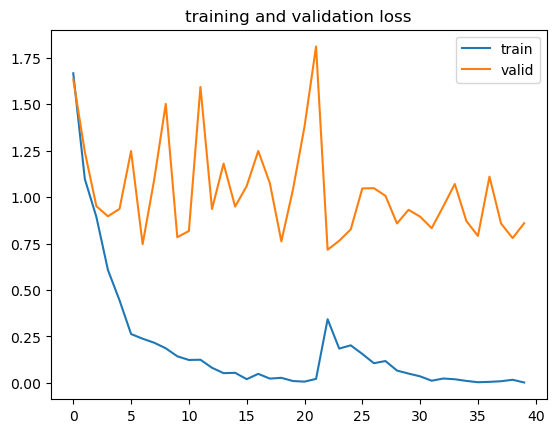

In [336]:
import matplotlib.pyplot as plt

plt.plot(range(epochs), train_losses, label='train')
plt.plot(range(epochs), valid_losses, label='valid')
plt.legend()
plt.title('training and validation loss')
plt.show()

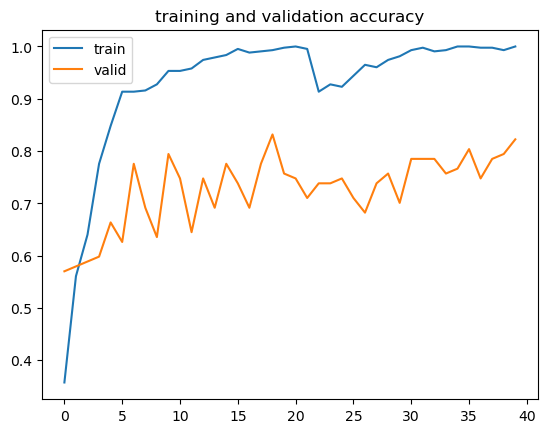

In [337]:
plt.plot(range(epochs), train_accuracies, label='train')
plt.plot(range(epochs), valid_accuracies, label='valid')
plt.legend()
plt.title('training and validation accuracy')
plt.show()

In [338]:
import pandas as pd
from datetime import datetime

metadata = pd.DataFrame({'epoch':range(epochs), 'train loss':train_losses, 'valid loss':valid_losses, 'train accu':train_accuracies, 'valid_accu':valid_accuracies})
metadata.to_csv(f'EmoDB_models/Wave2Vec_results/acc_loss/wav2vecbase_{layer}.csv ', index=False)

In [339]:
from sklearn.metrics import confusion_matrix

y_pred = []
y_true = []

for inputs, lengths, labels in test_dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    output = model(inputs, lengths) # Feed Network

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction

    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Save Truth

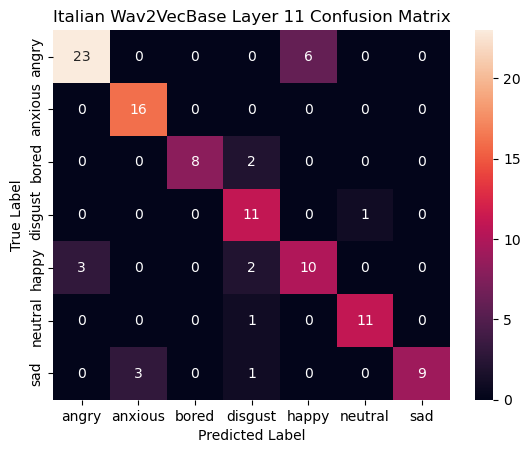

In [340]:
import numpy as np
cf = confusion_matrix(y_true, y_pred)
classes = list(data['Label'].unique())
df_cm = pd.DataFrame(cf, index = [i for i in classes],
                     columns = [i for i in classes])
sns.heatmap(df_cm, annot=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Italian Wav2VecBase Layer {layer} Confusion Matrix')
df_cm.to_csv(f'EmoDB_models/Wave2Vec_results/cm/cm_wav2vecbase_{layer}.csv ', index=False)

## 6. Check

In [341]:
print('done')

done
